 # Creation of a Neural Network from Scratch
 In this project we aim to create a Neural Network applied to the simple library MNIST for image classification. We will use just essential libraries of python to import the data and do the mathematical computations. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

The creation and update of the neural network is managed in the file NeuralNetworkLibrary.py

In [2]:
import NeuralNetworkLibrary as nnl

We can import the MNIST dataset directly from the library TensorFlow

## Load and processing of the Data

In [3]:
mnist = tf.keras.datasets.mnist
(x_train_matrix, y_train), (x_test_matrix, y_test) = mnist.load_data()

Since the data is saved in matrix form and we will not use convulational or pulling layer, we reshape the images in single vectors.

In [4]:
x_train = np.array([x_train_matrix[i].reshape(-1) for i in range(len(x_train_matrix))])
x_test = np.array([x_test_matrix[i].reshape(-1) for i in range(len(x_test_matrix))])

It is possible to visualize the data using the Pandas library additionally.

In [5]:
df_x = pd.DataFrame(x_train)
df_x['label'] = y_train
df_x.columns = [f'pixel_{i}' for i in range(784)] + ['label']
df_x.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


Before diving in the creation and training of the neural network, it is better to shuffle the training data and split it into a validation and training set.

The training set will be used indeed to train our model, while the validation set will be considered to estimate the level of overfitting of the model itself.

Being the pixel associated with values between 0 and 255, it is better to scale the from 0 to 1.

In [6]:
y_train = y_train.reshape(-1,1)
data =  np.concatenate((y_train, x_train), axis=1)
np.random.shuffle(data)

data_val = data[0:10000].T
Y_val = data_val[0]
X_val = data_val[1:] / 255

data_train = data[10000:].T
Y_train = data_train[0]
X_train = data_train[1:] /255

In [7]:
X_test = x_test.T / 255
Y_test = y_test.T

## Creation and training of the Neural Network

Using the library that I've create we can build and train our Neural Network 

Iteration 0
Accuracy : 0.11238
Iteration 200
Accuracy : 0.77082
Iteration 400
Accuracy : 0.8484


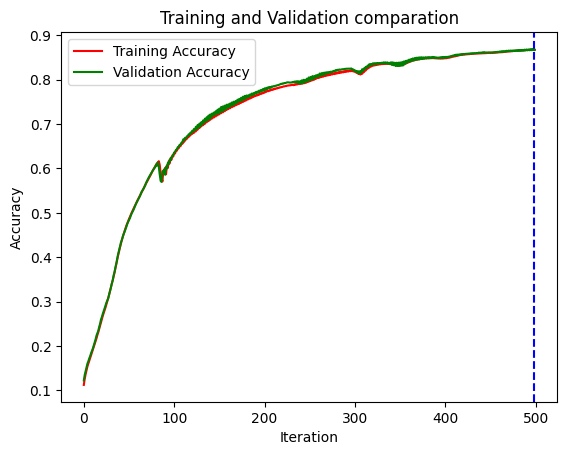

Training finished in 500 iterations
Final Accuracy : 0.86726
The training process took: 93.5363187789917 seconds


In [8]:
nn = nnl.NeuralNetwork([10,10,10], seed = 0)
duration, acc = nn.training_gradient_descent(X_train, Y_train, X_test, Y_test,show = True ,iterations= 500, alpha = 0.2)
print(f'The training process took: {duration} seconds')

In this representation of the architecture of the Neural Network I've decided to simply collapse all the 28x28 inputs in single cell for visualization purposes. Moreover, even if the output is a single value, due to the way it has been build this neural network we can consider the last hidden layer as the actual output layer. Indeed, this layer needs to have exactly 10 neurons, one for each of the 10 values that we aim to classify. By accepting only the highest between those quantities we can compute the prediction of the model.

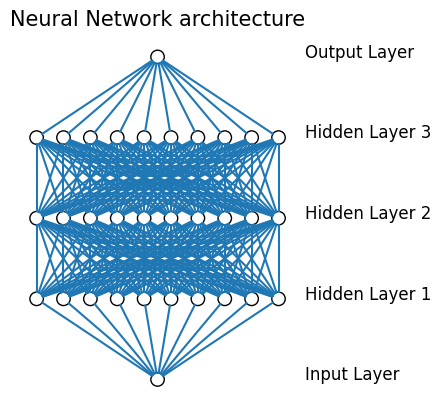

In [9]:
nn.draw()

## Testing

In this part I've imported some libraries often used for the creation of Neural Network to take advantages of the tools that they provide for the evaluation of the model.

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [11]:
predicted = nn.prediction(X_test)
print(f'Accuracy over the test set : {nnl.get_accuracy(predicted, Y_test)}')

Accuracy over the test set : 0.8671


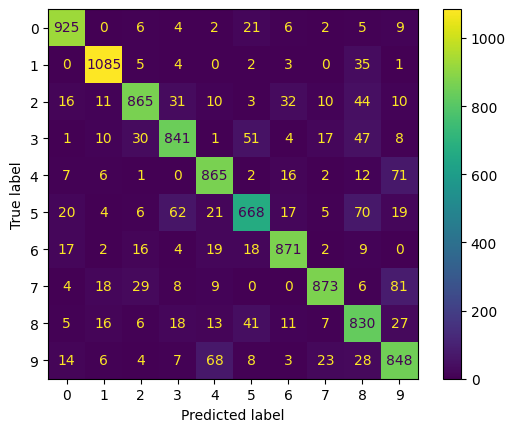

In [12]:
conf_matrix = confusion_matrix(Y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cm_display.plot()
plt.show()

## Show results

In this part we can evaluate the performances of the model by visualizing some random data from the test set and compare it with the prediction obtained.

In [13]:
def show_results(nn, X_test, i = -1):
    if i <0 or i>len(X_test):
        i = int(np.random.uniform( low = 0.0, high = len(X_test)))
    predicted = nn.prediction(X_test[:,i])
    plt.imshow(x_test_matrix[i], cmap='Greys',  interpolation='nearest')
    plt.suptitle(f'Real value: {y_test[i]}')
    plt.title(f'Predicted value: {predicted[0]}')

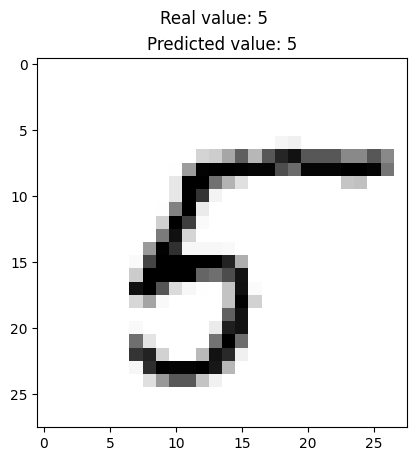

In [14]:
show_results(nn, X_test)

## Architecture Evaluation

In this section we aim to study the performances of varius architecture of the models, taking into account both the time required to train and model and the accuracy achieved on the test set. 

Training finished in 5000 iterations
Final Accuracy : 0.9176
Training finished in 5000 iterations
Final Accuracy : 0.9258
Training finished in 5000 iterations
Final Accuracy : 0.93172


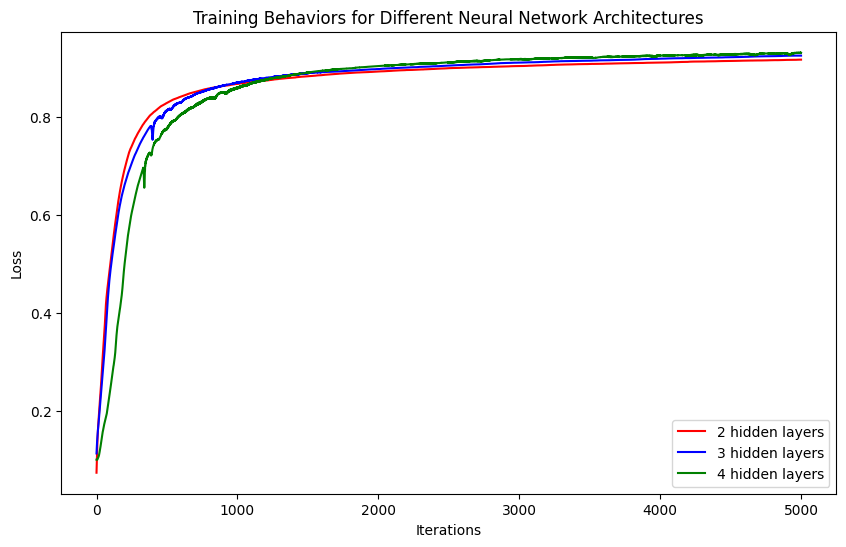

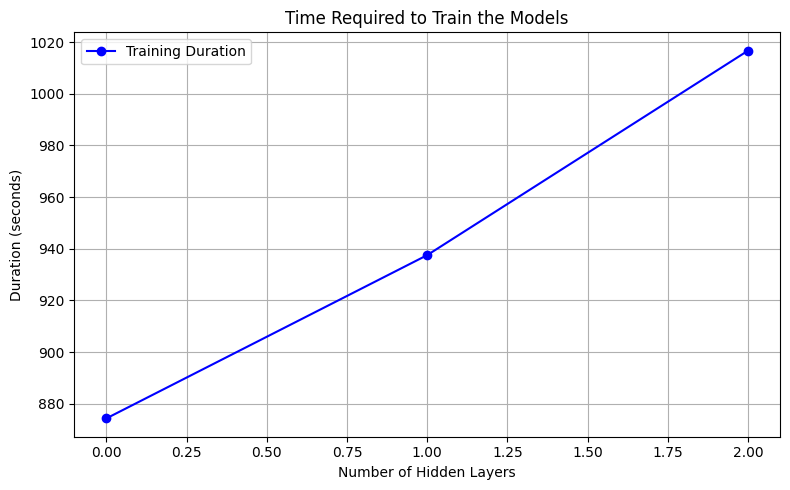

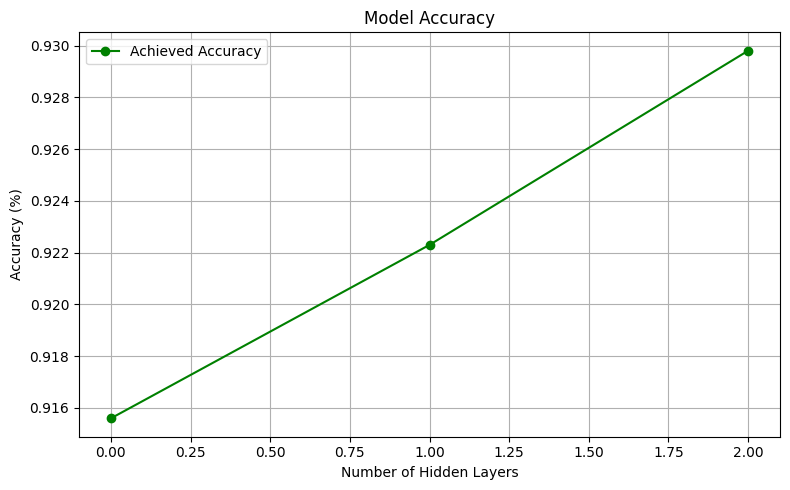

In [ ]:
durations = []
accuracies = []
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

plt.figure(figsize=(10, 6))  # Create a new figure for the behavior plot
for idx, n in enumerate(range(2, 5)):  # Use enumerate to manage index
    a = [10 for _ in range(n)]  # Define architecture with `n` hidden layers
    nn = nnl.NeuralNetwork(a, seed=0)  # Create neural network instance
    duration, behaviour = nn.training_gradient_descent(
        X_train, Y_train, X_test, Y_test, iterations=50
        00, alpha=0.1
    )
    durations.append(duration)
    predicted = nn.prediction(X_test)
    accuracy = nnl.get_accuracy(predicted, Y_test)
    accuracies.append(accuracy)
    label = f'{n} hidden layers'
    plt.plot(behaviour, color=colors[idx], label=label)  # Plot behavior with label

plt.title('Training Behaviors for Different Neural Network Architectures')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()  # Display the first plot

# Second plot: Training durations
plt.figure(figsize=(8, 5))  # Create a new figure for durations
plt.plot(durations, marker='o', color='b', label='Training Duration')
plt.title('Time Required to Train the Models')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Duration (seconds)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()  # Display the second plot

# Third plot: Achieved accuracies
plt.figure(figsize=(8, 5))  # Create a new figure for accuracies
plt.plot( accuracies, marker='o', color='g', label='Achieved Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()  # Display the third plot


In [16]:
nn.b[3].shape

(10, 1)